## Animal Crossing New Horizons : Comment être plus rentable en vendant des navets ?

Contexte:
Dans Animal Crossing New Horizons, nous avons la possibilité d'acheter des navets le dimanche matin de 5h à 12h. Ensuite, au cours de la semaine qui suit, nous pouvons revendre ces navets à un prix variant d'une demi-journée à l'autre (nous ne pouvons pas les vendre dimanche après-midi). 

Problématique: Il faut que je sache quand les vendre pour être la plus rentable possible.

Objectif: J'aimerais prédire au cours d'une semaine donnée la demi-journée durant laquelle je serai la plus rentable, donc j'aimerais maximiser le profit de la vente des navets.

Je vais tout d'abord importer les librairies et charger mon jeu de données.

### Comment ai-je obtenu les données ?
J'ai tout d'abord cherché sur Internet un jeu de données recensant le prix de chaque demi-journée par joueur par semaine. Au final, il faut collecter les données soi-même. J'ai donc web scrappé un site qui génère aléatoirement des semaines de prix, qui suivent des tendances connues pour être utilisées dans l'algorithme du jeu.
Au final, j'ai 9999 semaines (donc 9999 lignes) avec comme variables: prix d'achat et prix de vente des 12 demi-journées (13 colonnes). Vu que j'ai webscrappé un site générateur de données aléatoires, je n'ai pas de données manquantes. La seule chose qe j'ai dû vériifier est l'absence de doublons absolus.

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


# Load the data from the CSV file

file_path = 'turnips2.csv'

data = pd.read_csv(file_path)

# Get the number of rows in the DataFrame

number_of_rows = len(data)

number_of_rows

9999

Ici, j'ai fait en sorte que les prix de vente soient des profits.

In [2]:
time_slot_columns = [col for col in data.columns if col not in ['Purchase'] and not col.endswith('_Profit')]

# Initialisation d'un nouveau DataFrame pour stocker les profits
profits_data = pd.DataFrame()

# Calcul des profits pour chaque demi-journée et ajout dans le nouveau DataFrame
for column in time_slot_columns:  # Utilisation des colonnes identifiées précédemment
    profits_data[f'{column}_Profit'] = data[column] - data['Purchase']

# Affichage des colonnes du DataFrame des profits pour vérifier
profits_data.columns.tolist()

['Mon-AM_Profit',
 'Mon-PM_Profit',
 'Tues-AM_Profit',
 'Tues-PM_Profit',
 'Wed-AM_Profit',
 'Wed-PM_Profit',
 'Thurs-AM_Profit',
 'Thurs-PM_Profit',
 'Fri-AM_Profit',
 'Fri-PM_Profit',
 'Sat-AM_Profit',
 'Sat-PM_Profit']

Ici, je calcule la corrélation entre les prix

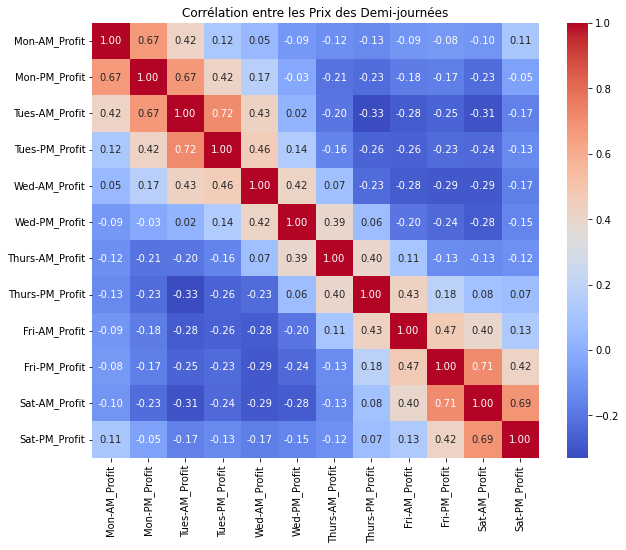

In [3]:
# Calcul de la corrélation entre les prix des demi-journées
correlation = profits_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Corrélation entre les Prix des Demi-journées')
plt.show()

1. Les profits des demi-journées consécutives ont tendance à être positivement corrélés, comme on peut le voir dans les cases rouges le long de la diagonale principale. Cela suggère que si le profit est élevé ou bas dans la matinée, il est probable qu'il le soit également l'après-midi.

2. Il existe également des corrélations positives modérées entre certaines demi-journées non consécutives, comme l'indiquent les tons de rouge et d'orange ailleurs dans la matrice.

3. Certains pairs de demi-journées ont des corrélations négatives faibles à modérées, comme indiqué par les teintes de bleu. Par exemple, il semble y avoir une faible corrélation négative entre les profits du jeudi matin et du lundi après-midi.

4. Beaucoup de cellules ont des couleurs proches du blanc, indiquant une corrélation faible ou nulle entre ces paires de demi-journées.

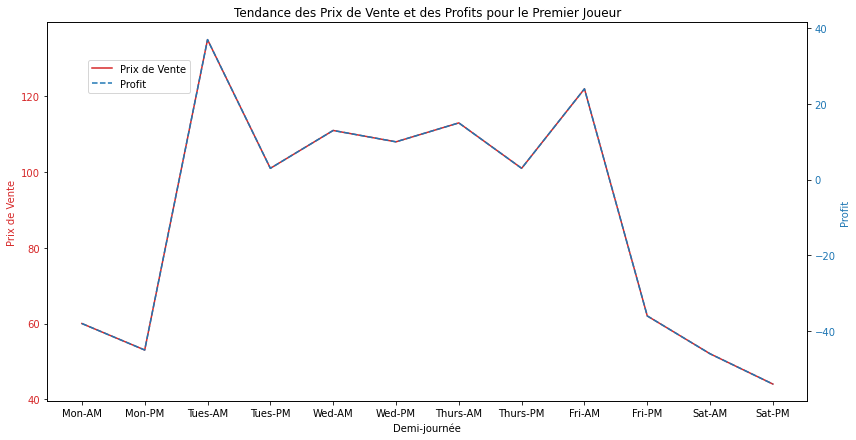

In [4]:
import matplotlib.pyplot as plt

# Supposons que vous souhaitez visualiser les données pour le premier joueur
player_data = data.iloc[0]

# Sélection des prix de vente pour le premier joueur pour chaque demi-journée
sale_prices = player_data[time_slot_columns]

# Sélection des profits pour le premier joueur pour chaque demi-journée
# Nous utilisons profits_data car il contient déjà les calculs de profit
profit_data = profits_data.iloc[0]

# Création d'une figure et d'un axe pour le tracé
fig, ax1 = plt.subplots(figsize=(12, 6))

# Tracé des prix de vente
color = 'tab:red'
ax1.set_xlabel('Demi-journée')
ax1.set_ylabel('Prix de Vente', color=color)
ax1.plot(time_slot_columns, sale_prices, color=color, label='Prix de Vente')
ax1.tick_params(axis='y', labelcolor=color)

# Création d'un deuxième axe pour les profits
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Profit', color=color)
ax2.plot(time_slot_columns, profit_data, color=color, linestyle='--', label='Profit')
ax2.tick_params(axis='y', labelcolor=color)

# Titre et légende
fig.tight_layout()
plt.title('Tendance des Prix de Vente et des Profits pour le Premier Joueur')
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))

plt.show()

In [9]:
from sklearn.cluster import KMeans
import numpy as np

# Préparation des données pour le clustering
# Ici, nous utilisons directement les prix des demi-journées comme caractéristiques
X_clustering = data[time_slot_columns] # Remplacer les NaN par 0 si nécessaire

# Application de K-Means pour clusteriser les tendances des prix
kmeans = KMeans(n_clusters=5, random_state=42)  # Utiliser un nombre approprié de clusters
clusters = kmeans.fit_predict(X_clustering)

# Ajout des labels de cluster au DataFrame original
data['Cluster'] = clusters

In [10]:
# Analyse descriptive des clusters, par exemple, calculer la moyenne des prix par cluster
for i in range(kmeans.n_clusters):
    cluster_mean_prices = data[data['Cluster'] == i][time_slot_columns].mean(axis=0)
    print(f"Cluster {i} mean prices:\n{cluster_mean_prices}\n")

Cluster 0 mean prices:
Mon-AM       74.877015
Mon-PM       70.694611
Tues-AM      66.783049
Tues-PM      62.837402
Wed-AM       58.963151
Wed-PM       68.864579
Thurs-AM     91.920774
Thurs-PM    134.339936
Fri-AM      206.203593
Fri-PM      208.529249
Sat-AM      134.916168
Sat-PM       91.122985
dtype: float64

Cluster 1 mean prices:
Mon-AM       88.026744
Mon-PM      102.393023
Tues-AM     144.008140
Tues-PM     289.748837
Wed-AM      281.081395
Wed-PM      142.739535
Thurs-AM     88.322093
Thurs-PM     65.425581
Fri-AM       65.304651
Fri-PM       63.717442
Sat-AM       63.860465
Sat-PM       64.826744
dtype: float64

Cluster 2 mean prices:
Mon-AM       80.941448
Mon-PM       76.920647
Tues-AM      72.833590
Tues-PM      74.554700
Wed-AM      102.143297
Wed-PM      139.471495
Thurs-AM    252.688752
Thurs-PM    250.358243
Fri-AM      141.872111
Fri-PM       83.439908
Sat-AM       64.811248
Sat-PM       63.607858
dtype: float64

Cluster 3 mean prices:
Mon-AM       88.104738
Mon-PM   

In [11]:
# Utilisation de K-Means pour le clustering
kmeans = KMeans(n_clusters=4, random_state=42)
data['Cluster'] = kmeans.fit_predict(data[time_slot_columns].fillna(0))